In [18]:
import numpy as np
import pandas as pd
import re
import string

# text processing & analysis lib
from textblob import TextBlob
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [23]:
df = pd.read_csv('datasets/spam.csv', encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [24]:
df.rename(columns={'v1':'class','v2':'sms'}, inplace=True)

threshold = 0.9
missing_percent = df.isnull().mean()
columns_to_drop = missing_percent[missing_percent > threshold].index
df = df.drop(columns = columns_to_drop)
df

,class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [25]:
print('Remaining columns: ',df.columns)
df.drop_duplicates()
df.sample(10)

Remaining columns:  Index(['class', 'sms'], dtype='object')


,class,sms
4880,ham,When/where do I pick you up
4552,ham,Sun ah... Thk mayb can if dun have anythin on....
701,ham,"Sorry, I'll call later"
752,ham,Dont gimme that lip caveboy
5363,ham,"I think your mentor is , but not 100 percent s..."
337,ham,Just sleeping..and surfing
3093,ham,Have you emigrated or something? Ok maybe 5.30...
4591,ham,Right it wasnt you who phoned it was someone w...
138,spam,You'll not rcv any more msgs from the chat svc...
1923,ham,Hello. They are going to the village pub at 8 ...


C:\Users\Aditya Singh\AppData\Local\Temp\ipykernel_12292\3383684026.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data = df, palette='hls')


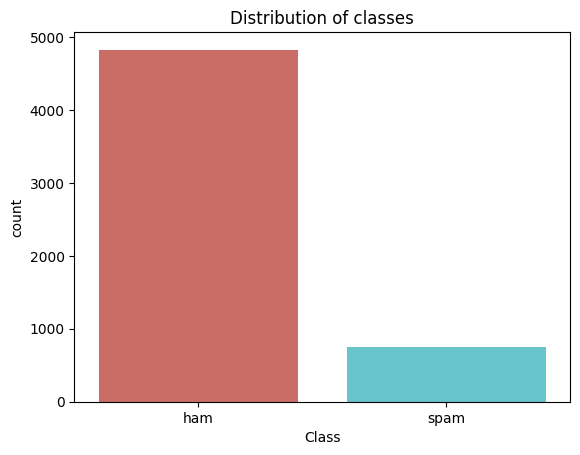

In [27]:
sns.countplot(x='class', data = df, palette='hls')
plt.title('Distribution of classes')
plt.xlabel('Class')
plt.ylabel('count')
plt.show()

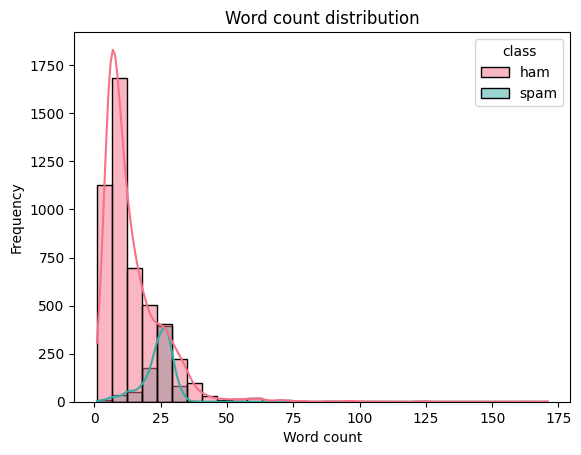

In [28]:
df['word_count'] = df['sms'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='word_count', hue='class', bins=30,kde=True, palette='husl')
plt.title('Word count distribution')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()   



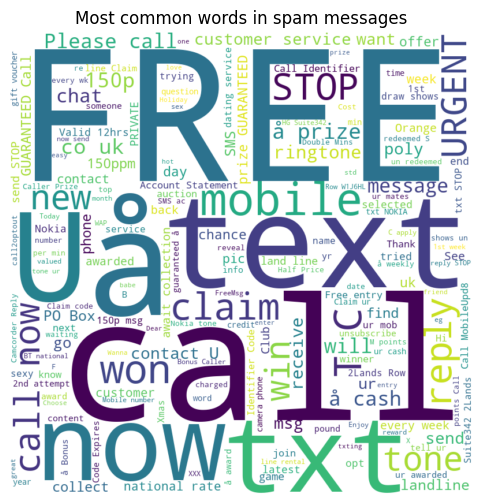

In [30]:
spam_text = df[df['class'] == 'spam']['sms'].str.cat(sep=' ')
wordcloud = WordCloud(width = 800, height=800, background_color='white', min_font_size=10).generate(spam_text)

plt.figure(figsize=(10,6), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in spam messages')
plt.show()

In [32]:
def remove_tags(text):
    pattern = re.compile('<[^>]+>')
    return pattern.sub(r'', text)
def remove_url(text):
    pattern  =re.compile(r'\b(?:https?|ftp|www)\S+\b')
    return pattern.sub(r"", text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
chat_words = {
    "AFAIK": "As Far As I Know",
"AFK": "Away From Keyboard",
"ASAP": "As Soon As Possible",
"ATK": "At The Keyboard",
"ATM": "At The Moment",
"A3": "Anytime, Anywhere, Anyplace",
"BAK": "Back At Keyboard",
"BBL": "Be Back Later",
"BBS": "Be Back Soon",
"BFN": "Bye For Now",
"B4N": "Bye For Now",
"BRB": "Be Right Back",
"BRT": "Be Right There",
"BTW": "By The Way",
"B4": "Before",
"B4N": "Bye For Now",
"CU": "See You",
"CUL8R": "See You Later",
"CYA": "See You",
"FAQ": "Frequently Asked Questions",
"FC": "Fingers Crossed",
"FWIW": "For What It's Worth",
"FYI": "For Your Information",
"GAL": "Get A Life",
"GG": "Good Game",
"GN": "Good Night",
"GMTA": "Great Minds Think Alike",
"GR8": "Great!",
"G9": "Genius",
"IC": "I See",
"ICQ": "I Seek you (also a chat program)",
"ILU": "ILU: I Love You",
"IMHO": "In My Honest/Humble Opinion",
"IMO": "In My Opinion",
"IOW": "In Other Words",
"IRL": "In Real Life",
"KISS": "Keep It Simple, Stupid",
"LDR": "Long Distance Relationship",
"LMAO": "Laugh My A.. Off",
"LOL": "Laughing Out Loud",
"LTNS": "Long Time No See",
"L8R": "Later",
"MTE": "My Thoughts Exactly",
"M8": "Mate",
"NRN": "No Reply Necessary",
"OIC": "Oh I See",
"PITA": "Pain In The A..",
"PRT": "Party",
"PRW": "Parents Are Watching",
"QPSA?": "Que Pasa?",
"ROFL": "Rolling On The Floor Laughing",
"ROFLOL": "Rolling On The Floor Laughing Out Loud",
"ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
"SK8": "Skate",
"STATS": "Your sex and age",
"ASL": "Age, Sex, Location",
"THX": "Thank You",
"TTFN": "Ta-Ta For Now!",
"TTYL": "Talk To You Later",
"U": "You",
"U2": "You Too",
"U4E": "Yours For Ever",
"WB": "Welcome Back",
"WTF": "What The F...",
"WTG": "Way To Go!",
"WUF": "Where Are You From?",
"W8": "Wait...",
"7K": "Sick:-D Laugher",
"TFW": "That feeling when",
"MFW": "My face when",
"MRW": "My reaction when",
"IFYP": "I feel your pain",
"TNTL": "Trying not to laugh",
"JK": "Just kidding",
"IDC": "I don't care",
"ILY": "I love you",
"IMU": "I miss you",
"ADIH": "Another day in hell",
"ZZZ": "Sleeping, bored, tired",
"WYWH": "Wish you were here",
"TIME": "Tears in my eyes",
"BAE": "Before anyone else",
"FIMH": "Forever in my heart",
"BSAAW": "Big smile and a wink",
"BWL": "Bursting with laughter",
"BFF": "Best friends forever",
"CSL": "Can't stop laughing"
}

def chat_conversion(text):
    new_text = []
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
    return ' '.join(new_text)
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word.lower() not in stop_words]
    return ' '.join(words)

punct = string.punctuation
exclude = set(punct)
def remove_punctuation(text):
    for char in exclude:
        text = text.replace(char, '')

    return text
df['sms'] = df['sms'].str.lower()
df['sms'] = df['sms'].apply(remove_tags)
df['sms'] = df['sms'].apply(remove_url)
df['sms'] = df['sms'].apply(remove_emojis)
df['sms'] = df['sms'].apply(chat_conversion)
df['sms'] = df['sms'].apply(remove_stopwords)
df['sms'] = df['sms'].apply(remove_punctuation)

In [33]:
label = LabelEncoder()
df['class'] = label.fit_transform(df['class'])

tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df['sms']).toarray()
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32),torch.tensor(y_train.values, dtype=torch.long))

test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32),torch.tensor(y_test.values, dtype=torch.long))

train_load = DataLoader(train_data, batch_size=32, shuffle=True)
test_load = DataLoader(test_data, batch_size=32)

class SpamClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 2)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x
model = SpamClassifier(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [35]:
epo = 10
for i in range(epo):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_load:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {i+1}, Loss: {running_loss/len(train_load)}')

    

Epoch 1, Loss: 0.30637622973216433
Epoch 2, Loss: 0.08775590317589896
Epoch 3, Loss: 0.05363579358506416
Epoch 4, Loss: 0.03988526462011838
Epoch 5, Loss: 0.03053436147913869
Epoch 6, Loss: 0.022416159136212498
Epoch 7, Loss: 0.0185470351333996
Epoch 8, Loss: 0.01436114970230327
Epoch 9, Loss: 0.012650372029747814
Epoch 10, Loss: 0.010994268470052962


In [36]:
model.eval()
y_pred_nn = []
with torch.no_grad():
    for inputs, _ in test_load:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred_nn.extend(predicted.tolist())
nn_accuracy = accuracy_score(y_test, y_pred_nn)
print('Accuracy of Neural Network: ', nn_accuracy)

Accuracy of Neural Network:  0.9695067264573991


In [37]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_accuracy = accuracy_score(y_test, lr.predict(X_test))
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_accuracy = accuracy_score(y_test, rf.predict(X_test))
print(f"Random Forest Accuracy: {rf_accuracy}")

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
svm_accuracy = accuracy_score(y_test, svm.predict(X_test))
print(f"SVM Accuracy: {svm_accuracy}")

Logistic Regression Accuracy: 0.9623318385650225
Random Forest Accuracy: 0.97847533632287
SVM Accuracy: 0.9730941704035875


In [38]:
results = {
    'Neural Network': nn_accuracy,
    'Logistic Regression': lr_accuracy,
    'Random Forest': rf_accuracy,
    'SVM': svm_accuracy
}
best_model = max(results, key=results.get)
print(f"Best model is {best_model} with accuracy of {results[best_model]}")

Best model is Random Forest with accuracy of 0.97847533632287
